In [2]:
import math
import numpy as np

import mido
import librosa
import librosa.display

import IPython.display as ipd
import matplotlib.pyplot as plt
from torch import optim

import torch.nn.functional as F
from torch import nn
import torch

windowSize=50

In [3]:
y, sr = librosa.load('4Beats2MelLong3.wav')

In [4]:
D = librosa.stft(y)

In [5]:
#ipd.Audio(y_hat,rate=sr) # load a local WAV file
ipd.Audio(y,rate=sr) # load a local WAV file

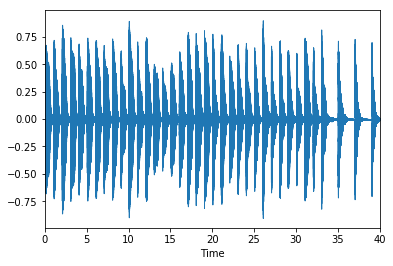

In [6]:
librosa.display.waveplot(y, sr=sr);

In [7]:
midiArray=[]
HopSize=0.023
timeTracker=0.0
totalTimeTracker=0.0
MemoryArray=np.zeros(128)
lasttime=0;
bpm=60
for msg in mido.MidiFile('4Beats2MelLong3.mid'):
    if not msg.is_meta:
        totalTimeTracker+=msg.time
        nextEventTime=lasttime+msg.time
        while nextEventTime> timeTracker + HopSize:
            MemoryArray[127]=((timeTracker%4) * (bpm/60.0))/4.0
            midiArray.append(MemoryArray.copy())
            timeTracker += HopSize;
        if msg.type=='note_on':
            MemoryArray[msg.note]+=1.0;
        elif msg.type=='note_off':
            MemoryArray[msg.note]-=1.0;
        if(timeTracker+msg.time >= timeTracker + HopSize):
            MemoryArray[127]=((timeTracker%4) * (bpm/60.0))/4.0
            midiArray.append(MemoryArray.copy())
            timeTracker += HopSize
        lasttime += msg.time
    else:
        if(msg.type == 'set_tempo'):
            bpm=60000000/msg.tempo
        

(1723, 1025) (1718, 128)


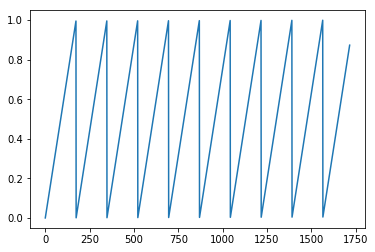

[0.      0.00575 0.0115  ... 0.86125 0.867   0.87275]


In [8]:
midiArray=np.float32(np.array(midiArray))
D_t=D.T
print(D_t.shape,midiArray.shape)
plt.plot(midiArray[:,127])
plt.show()
print(midiArray[:,127])

In [9]:
minLength = min(midiArray.shape[0],D_t.real.shape[0])

D_data=D_t[:minLength].real;
midiArray=midiArray[:minLength];
print(midiArray.shape,D_data.shape)
print(midiArray.dtype,D_data.dtype)

(1718, 128) (1718, 1025)
float32 float32


In [10]:

outPutMidiArray=[]
for i in range(midiArray.shape[0]):
    temp=[]
    for j in range(windowSize):
        val = int(j-(np.floor(windowSize/2)))
        val = i+val
        if(val<0 or val+1>midiArray.shape[0]):
             temp.append(np.zeros(midiArray.shape[1]))
        else:
            temp.append(midiArray[val])
    outPutMidiArray.append(temp)
outPutMidiArray=np.array(outPutMidiArray)

In [11]:
print(outPutMidiArray.shape)

(1718, 50, 128)


In [12]:
## Solution

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Defining the layers, 128, 64, 10 units each
        self.fc1 = nn.Linear(128*windowSize, int(128*windowSize/2))
        self.fc2 = nn.Linear(int(128*windowSize/2), 1000)
        self.fc3 = nn.Linear(1000, 1025)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        return x

model = Network()
model

Network(
  (fc1): Linear(in_features=6400, out_features=3200, bias=True)
  (fc2): Linear(in_features=3200, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=1025, bias=True)
)

In [13]:
import torch.utils.data as utils


tensor_x = torch.stack([torch.Tensor(i) for i in np.abs(outPutMidiArray)]) # transform to torch tensors
tensor_y = torch.stack([torch.Tensor(i) for i in np.abs(D_data)])
tensor_x = tensor_x.view(tensor_x.shape[0],-1)
print(tensor_x.shape,tensor_y.shape)
my_dataset = utils.TensorDataset(tensor_x,tensor_y) # create your datset
my_dataloader = utils.DataLoader(my_dataset,batch_size=64,shuffle=True) # create your dataloader

my_testloader = utils.DataLoader(my_dataset) # create your dataloader


# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)

criterion = nn.MSELoss()
# or criterion = nn.MSELoss()
# Get our data


torch.Size([1718, 6400]) torch.Size([1718, 1025])


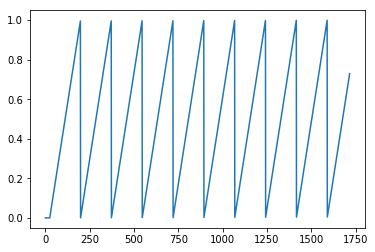

In [14]:
plt.plot(tensor_x.numpy()[:,127])
plt.show()

In [17]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Counter=0;
LossOverEpoch=[]
model.train()
model.to(device)

Network(
  (fc1): Linear(in_features=6400, out_features=3200, bias=True)
  (fc2): Linear(in_features=3200, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=1025, bias=True)
)

In [ ]:
epochs = 500
for i in range(epochs):
    running_loss = 0
    for data, labels in my_dataloader:
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()     
        logits = model(data)
        loss =criterion(logits,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    else:
        LossOverEpoch.append(running_loss)
        print(f"Training loss: {running_loss/len(my_dataloader)}" +"   "+ str(Counter))
        Counter+=1

Training loss: 1.8071208441698994   1500
Training loss: 1.8067315110453852   1501
Training loss: 1.8075020357414529   1502
Training loss: 1.8145607047610812   1503
Training loss: 1.8029903570810955   1504
Training loss: 1.8052049919410988   1505
Training loss: 1.8033436470561557   1506
Training loss: 1.808176596959432   1507
Training loss: 1.7992229461669922   1508
Training loss: 1.802799105644226   1509
Training loss: 1.8003506483855072   1510
Training loss: 1.8025872795670121   1511
Training loss: 1.8017804578498557   1512
Training loss: 1.799703558286031   1513
Training loss: 1.796898983142994   1514
Training loss: 1.794737701062803   1515
Training loss: 1.7945068765569616   1516
Training loss: 1.7929204967286851   1517
Training loss: 1.794322102158158   1518
Training loss: 1.7967737780676947   1519
Training loss: 1.7903839614656236   1520
Training loss: 1.7940484550264146   1521
Training loss: 1.792956308082298   1522
Training loss: 1.7913376048759178   1523
Training loss: 1.790091

Training loss: 1.649555038522791   1702
Training loss: 1.6501226116109777   1703
Training loss: 1.6470118584456268   1704
Training loss: 1.6469322354705245   1705
Training loss: 1.6510033695786088   1706
Training loss: 1.645640214284261   1707
Training loss: 1.64719381597307   1708
Training loss: 1.645708198900576   1709
Training loss: 1.6435044562375103   1710
Training loss: 1.6478978307158858   1711
Training loss: 1.649530088460004   1712
Training loss: 1.6444443508430764   1713
Training loss: 1.650225943989224   1714
Training loss: 1.6469172327606767   1715
Training loss: 1.6410347399888214   1716
Training loss: 1.6375562614864774   1717
Training loss: 1.6388092614986278   1718
Training loss: 1.6422732582798711   1719
Training loss: 1.636753135257297   1720
Training loss: 1.639222259874697   1721
Training loss: 1.6380382732108787   1722
Training loss: 1.6371534621274029   1723
Training loss: 1.6352570719189115   1724
Training loss: 1.6318539910846286   1725
Training loss: 1.63524104

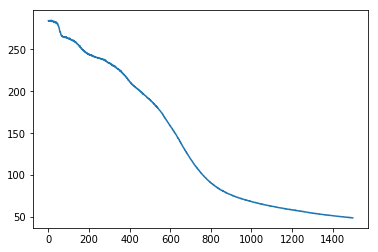

In [23]:
plt.plot(LossOverEpoch)
plt.show()
#torch.save(model.state_dict(), './w10-3270Epochs.model')

In [28]:
model.eval()
outputArray=[]
for data, labels in my_testloader:
    with torch.no_grad():
        data, labels = data.to(device), labels.to(device)
        output = model.forward(data)
        outputArray.append(output[0].cpu().numpy())
outputArray=np.array(outputArray).T

In [29]:
print((outputArray).shape)
Y_infered = librosa.istft(outputArray) 

(1025, 1718)


In [30]:
ipd.Audio(Y_infered,rate=sr)

In [31]:
ipd.Audio(y,rate=sr)

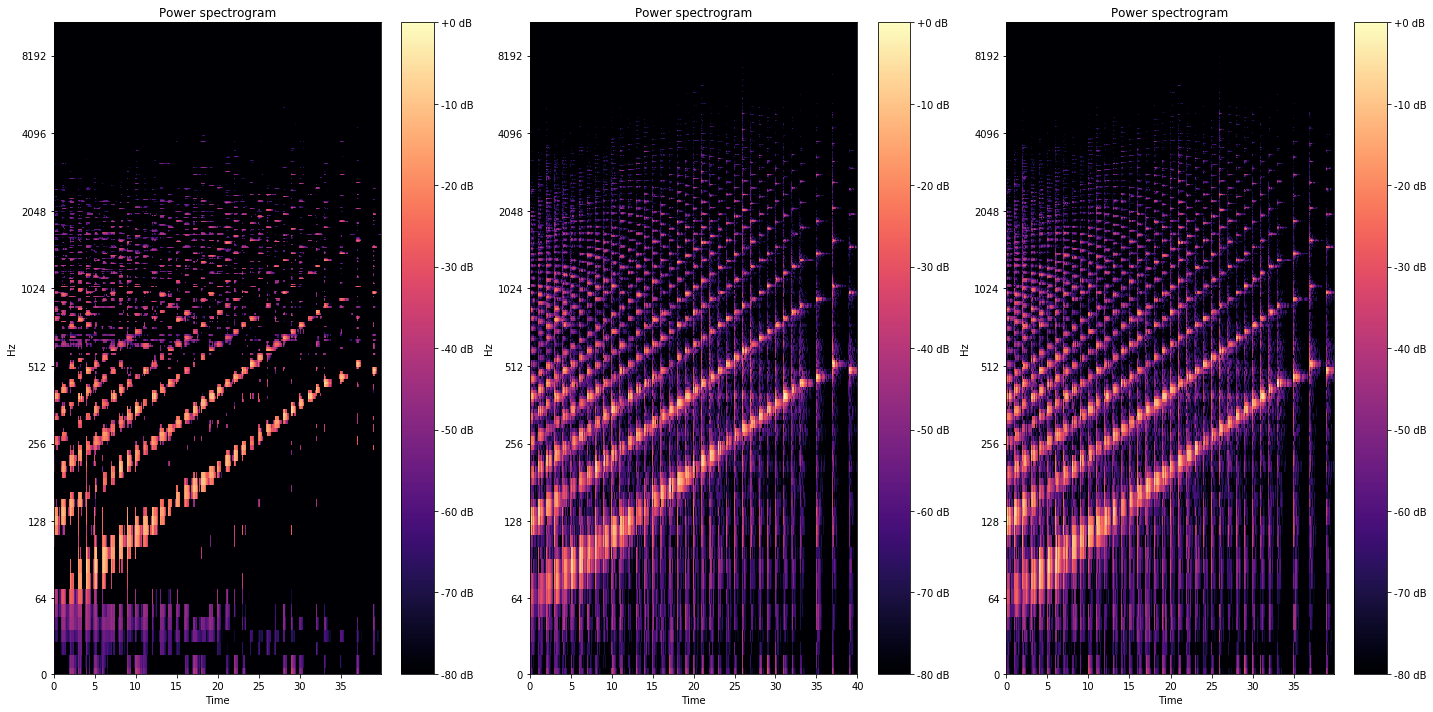

In [32]:

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
librosa.display.specshow(librosa.amplitude_to_db(outputArray,
                                                  ref=np.max),
                          y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

plt.subplot(1,3,2)
librosa.display.specshow(librosa.amplitude_to_db(D.real,
                                                  ref=np.max),
                          y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()


plt.subplot(1,3,3)
librosa.display.specshow(librosa.amplitude_to_db(tensor_y.numpy().T,
                                                  ref=np.max),
                          y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()


In [35]:
output=np.array(0);
with torch.no_grad():
        test=torch.zeros([1, 128*windowSize], dtype=torch.float32)
       # test[0][46]=0.0;
        data  = data.to(test)
        output = model.forward(data)
      #  test2=torch.ones([1, 1025], dtype=torch.float32)
      #  test2[0][46]=0.0;
        loss = criterion(output,torch.zeros([1, 1025], dtype=torch.float32))
        print(loss.item())
print(output.numpy()[0].shape,D_data[250].shape)
plt.plot(output.numpy()[0],'r')
#plt.plot(D_data[250],'g')
plt.show()

RuntimeError: Expected object of backend CUDA but got backend CPU for argument #4 'mat1'

In [ ]:
print(output.numpy()[0].shape)

In [36]:
midiTestArray=[]
HopSize=0.023
timeTracker=0.0
totalTimeTracker=0.0
MemoryArray=np.zeros(128)
lasttime=0;
bpm=60
for msg in mido.MidiFile('4Beats2Mel.mid'):
    if not msg.is_meta:
        totalTimeTracker+=msg.time
        nextEventTime=lasttime+msg.time
        while nextEventTime> timeTracker + HopSize:
            MemoryArray[127]=((timeTracker%4) * (bpm/60.0))/4.0
            midiTestArray.append(MemoryArray.copy())
            timeTracker += HopSize;
        if msg.type=='note_on':
            MemoryArray[msg.note]+=1.0;
        elif msg.type=='note_off':
            MemoryArray[msg.note]-=1.0;
        if(timeTracker+msg.time >= timeTracker + HopSize):
            MemoryArray[127]=((timeTracker%4) * (bpm/60.0))/4.0
            midiTestArray.append(MemoryArray.copy())
            timeTracker += HopSize
        lasttime += msg.time
    else:
        if(msg.type == 'set_tempo'):
            bpm=60000000/msg.tempo
midiTestArray = np.float32(np.array(midiTestArray))

MainMidiTest=[]
for i in range(midiTestArray.shape[0]):
    temp=[]
    for j in range(windowSize):
        val = int(j-(np.floor(windowSize/2)))
        val = i+val
        if(val<0 or val+1>midiTestArray.shape[0]):
             temp.append(np.zeros(midiTestArray.shape[1]))
        else:
            temp.append(midiTestArray[val])
    MainMidiTest.append(temp)
MainMidiTest=np.array(MainMidiTest)



tensor_x_test = torch.stack([torch.Tensor(i) for i in np.abs(MainMidiTest)])
tensor_x_test = tensor_x_test.view(tensor_x_test.shape[0],-1)

testDataSet = utils.TensorDataset(tensor_x_test,torch.zeros(tensor_x_test.shape)) # create your datset
TestLoader = utils.DataLoader(testDataSet) # create your dataloader


model.eval()
outputArray=[]
for data, labels in TestLoader:
    with torch.no_grad():
        output = model.forward(data)
        outputArray.append(output[0].numpy())
outputArray=np.array(outputArray).T
print((outputArray).shape)
Y_infered2 = librosa.istft(outputArray) 

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
librosa.display.specshow(librosa.amplitude_to_db(outputArray,
                                                  ref=np.max),
                          y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

plt.subplot(1,2,2)
plt.imshow(midiTestArray.T,interpolation='nearest', aspect='auto')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

plt.show();


ipd.Audio(Y_infered2,rate=sr)

RuntimeError: Expected object of backend CUDA but got backend CPU for argument #4 'mat1'

In [ ]:
librosa.display.waveplot(y[:500], sr=sr);